##Packages and Helper Functions

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
import numpy as np
import optuna
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

## Utility Functions

In [ ]:
# Functions to preprocess data
def expand_class(df: pd.DataFrame, header: str, classes: list[str]):
    df_cpy = df
    for class_name in classes:
        df_cpy[class_name] = (df_cpy[header] == class_name).astype(int)
    df_cpy.drop(header, axis='columns', inplace=True)
    return df_cpy

def numerize_csv(path: str, train: bool=True, expand_classes: bool=False):
    ''' Takes a path to a project csv and converts its entries to numerical '''
    df = pd.read_csv(path)
    df['gender'] = (df['gender'] == 'Female').astype(int)

    for header in ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']:
        df[header] = (df[header] == 'Yes').astype(int)

    for header in ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', \
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
        # some here have the value no phone/internet service, which are casted to 0
        df[header] = (df[header] == 'Yes').astype(int)

    for header in ['MonthlyCharges', 'TotalCharges', 'tenure']:
        # lines that need normalization
        df[header] /= (max(df[header]) - min(df[header]))

    if train:
        df['Discontinued'] = (df['Discontinued'] == 'Yes').astype(int)

    if not expand_classes:
        df['InternetService'] = df['InternetService'].map({'Fiber optic': 2, 'DSL': 1, 'No': 0})
        df['Contract'] = df['Contract'].map({'Two year': 2, 'One year': 1, 'Month-to-month': 0})
        # Note that the PaymentMethod column contains some entries that are marked automatic
        # that's probably correlated with discontinuation in some way.
        df['PaymentMethod'] = df['PaymentMethod'].map({
            'Credit card (automatic)': 3,
            'Electronic check': 1,
            'Bank transfer (automatic)': 2,
            'Mailed check': 0})
    else:
        df = expand_class(df, 'PaymentMethod', ['Credit card (automatic)', 'Electronic check', 'Bank transfer (automatic)', 'Mailed check'])
        df = expand_class(df, 'Contract', ['Two year', 'One year', 'Month-to-month'])
        df = expand_class(df, 'InternetService', ['Fiber optic', 'DSL', 'No'])

    df.drop('customerID', axis=1, inplace=True)

    if train: df.fillna(0, inplace=True)
    else:
        mean = df.mean()
        df.fillna(mean, inplace=True)
    return df

def combine_related_columns(df: pd.DataFrame):
    ''' Takes a project dataframe and combines its related rows. '''
    df_cpy = df
    PHONE_SERVICE_WEIGHT = 0.2
    TV_STREAM_WEIGHT = 0.9
    SECURITY_WEIGHTS = {
        'security': 0.4,
        'backup': 0.4,
        'protection': 0.1,
        'support': 0.1
    }
    df_cpy['PhoneUsageScore'] = df_cpy.pop('PhoneService').values * PHONE_SERVICE_WEIGHT \
                                + df_cpy.pop('MultipleLines').values * (1 - PHONE_SERVICE_WEIGHT)
    df_cpy['InternetSecurityScore'] = df_cpy.pop('OnlineSecurity').values * SECURITY_WEIGHTS.get('security') \
                                        + df_cpy.pop('OnlineBackup').values * SECURITY_WEIGHTS.get('backup') \
                                        + df_cpy.pop('DeviceProtection').values * SECURITY_WEIGHTS.get('protection') \
                                        + df_cpy.pop('TechSupport').values * SECURITY_WEIGHTS.get('support')
    df_cpy['InternetStreamingScore'] = df_cpy.pop('StreamingTV').values * TV_STREAM_WEIGHT \
                                        + df_cpy.pop('StreamingMovies').values * (1 - TV_STREAM_WEIGHT)
    return df_cpy

def write_submission(preds):
    ''' Utility function to write to the submission file. '''
    df = pd.read_csv('submission.csv')
    pred_len = len(preds)
    target_len = len(df['ID'])
    if pred_len != target_len:
        raise ValueError(f'Incorrect input length. Required: {target_len}. Provided: {pred_len}')
    df['TARGET'] = pd.Series(preds)
    df.set_index('ID', inplace=True)
    df.to_csv('submission.csv')

In [ ]:
# Functions to run cross validation and generate plots
def get_cross_validation_accuracies(clf, kf, X, Y):
    fold_accs = np.zeros((kf.get_n_splits(X), 6))
    for j, (train_index, test_index) in enumerate(kf.split(X)):
        X_train = X[train_index]
        X_test = X[test_index]
        y_train = Y[train_index]
        y_test = Y[test_index]

        clf.fit(X_train, y_train)
        y_test_preds = clf.predict(X_test)
        y_train_preds = clf.predict(X_train)
        y_test_prob_preds = clf.predict_proba(X_test)
        y_train_prob_preds = clf.predict_proba(X_train)

        fold_accs[j,0] = roc_auc_score(y_test, y_test_preds)
        fold_accs[j,1] = roc_auc_score(y_train, y_train_preds)
        fold_accs[j,2] = roc_auc_score(y_test, y_test_prob_preds[:, 1])
        fold_accs[j,3] = roc_auc_score(y_train, y_train_prob_preds[:, 1])
        fold_accs[j,4] = accuracy_score(y_test, y_test_preds)
        fold_accs[j,5] = accuracy_score(y_train, y_train_preds)

    return np.average(fold_accs, axis=0)

def plot_accuracies(x_vals, accuracies, condensed, title, xlabel, ylabel):
    if not condensed:
        plt.plot(x_vals, accuracies[:,0], label="ROC AUC Testing")
        plt.plot(x_vals, accuracies[:,1], label="ROC AUC Training")
        plt.plot(x_vals, accuracies[:,2], label="ROC AUC Testing with Probabilities")
        plt.plot(x_vals, accuracies[:,3], label="ROC AUC Training with Probabilities")
        plt.plot(x_vals, accuracies[:,4], label="Testing")
        plt.plot(x_vals, accuracies[:,5], label="Training")
    else:
        plt.plot(x_vals, accuracies[:,0], label="Testing")
        plt.plot(x_vals, accuracies[:,1], label="Training")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

##Prepare Data

In [ ]:
# Get Training Data and Preprocess
raw = numerize_csv('train.csv', expand_classes=True)
# combined=combine_related_columns(raw)

Y = raw['Discontinued'].to_numpy()
X = raw.drop('Discontinued', axis=1).to_numpy()

kf = KFold(n_splits=5)

# X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, train_size = .75)

## Model 1: AdaBoost Classifier

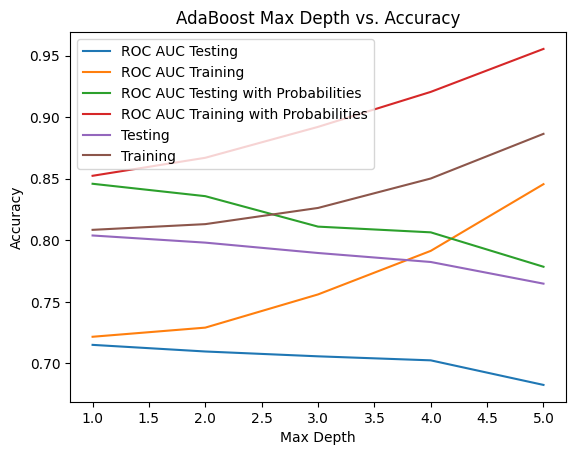

In [ ]:
# Test AdaBoost with different max depths
max_depths = [1, 2, 3, 4, 5]
accuracies = np.zeros((len(max_depths), 6))
for (i, depth) in enumerate(max_depths):
    base_estimator = DecisionTreeClassifier(criterion="gini", max_depth=depth)
    clf = AdaBoostClassifier(estimator=base_estimator, n_estimators=20, random_state=0)

    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

plot_accuracies(max_depths, accuracies, False, "AdaBoost Max Depth vs. Accuracy", "Max Depth", "Accuracy")

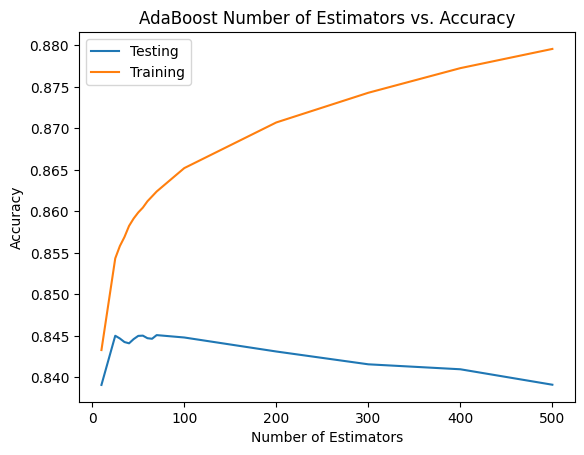

In [ ]:
# Test AdaBoost with different n_estimators
num_estimators = [10, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 100, 200, 300, 400, 500]
accuracies = np.zeros((len(num_estimators), 6))
for (i, num) in enumerate(num_estimators):
    base_estimator = DecisionTreeClassifier(criterion="gini", max_depth=1)
    clf = AdaBoostClassifier(estimator=base_estimator, n_estimators=num, random_state=0)

    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

plot_accuracies(num_estimators, accuracies[:,[2,3]], True, "AdaBoost Number of Estimators vs. Accuracy", "Number of Estimators", "Accuracy")

In [ ]:
# Compare Gini vs. Entropy loss for AdaBoost
num_trials = 100
accuracies = np.zeros((100, 6))
print("Gini: ")
for i in range(num_trials):
    base_estimator = DecisionTreeClassifier(criterion="gini", max_depth=1)
    clf = AdaBoostClassifier(estimator=base_estimator, n_estimators=40)

    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

print(f'ROC AUC Testing Accuracy: {np.mean(accuracies[:,0])}')
print(f'ROC AUC Training Accuracy: {np.mean(accuracies[:,1])}')
print(f'ROC AUC Testing Accuracy with Probabilities: {np.mean(accuracies[:,2])}')
print(f'ROC AUC Training Accuracy with Probabilities: {np.mean(accuracies[:,3])}')
print(f'Testing Accuracy: {np.mean(accuracies[:,4])}')
print(f'Training Accuracy: {np.mean(accuracies[:,5])}')

num_trials = 100
accuracies = np.zeros((100, 6))
print("Entropy: ")
for i in range(num_trials):
    base_estimator = DecisionTreeClassifier(criterion="entropy", max_depth=1)
    clf = AdaBoostClassifier(estimator=base_estimator, n_estimators=40)

    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

print(f'ROC AUC Testing Accuracy: {np.mean(accuracies[:,0])}')
print(f'ROC AUC Training Accuracy: {np.mean(accuracies[:,1])}')
print(f'ROC AUC Testing Accuracy with Probabilities: {np.mean(accuracies[:,2])}')
print(f'ROC AUC Training Accuracy with Probabilities: {np.mean(accuracies[:,3])}')
print(f'Testing Accuracy: {np.mean(accuracies[:,4])}')
print(f'Training Accuracy: {np.mean(accuracies[:,5])}')

# Entropy seems to slightly better (perhaps negligible)

Gini: 
ROC AUC Testing Accuracy: 0.714628371178858
ROC AUC Training Accuracy: 0.7244119042198546
ROC AUC Testing Accuracy with Probabilities: 0.8441070742397596
ROC AUC Training Accuracy with Probabilities: 0.8582480207746117
Testing Accuracy: 0.804976473514748
Training Accuracy: 0.8125584152238341
Entropy: 
ROC AUC Testing Accuracy: 0.7186180082043258
ROC AUC Training Accuracy: 0.7257269384060473
ROC AUC Testing Accuracy with Probabilities: 0.8448482064957108
ROC AUC Training Accuracy with Probabilities: 0.8581625069908974
Testing Accuracy: 0.8081582423280532
Training Accuracy: 0.8131199281935924


##Model 2: Random Forest Classifier

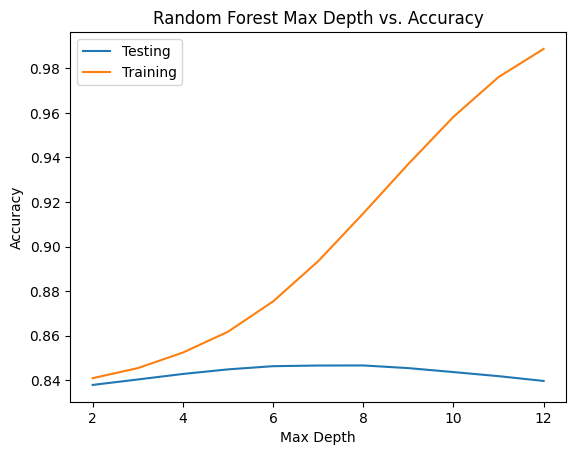

In [ ]:
# Test RandomForest different max_depths
max_depths = np.arange(2, 12 + 1, 1)
accuracies = np.zeros((len(max_depths), 6))
for (i, depth) in enumerate(max_depths):
    clf = RandomForestClassifier(n_estimators=1000, random_state=0, criterion="entropy")
    clf.set_params(max_depth = depth)

    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

plot_accuracies(max_depths, accuracies[:, [2,3]], True, "Random Forest Max Depth vs. Accuracy", "Max Depth", "Accuracy")

# Max Depth of 7 seems to work best: 0.84659 test accuracy

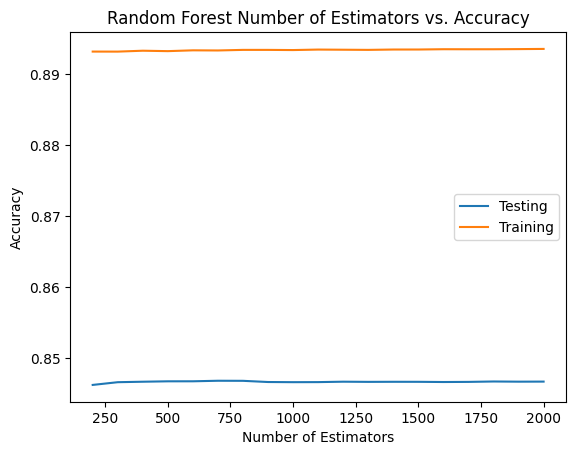

In [ ]:
# Test RandomForest with different n_estimators
num_estimators = np.arange(200, 2000 + 1, 100)
accuracies = np.zeros((len(num_estimators), 6))
for (i, num) in enumerate(num_estimators):

    clf = RandomForestClassifier(n_estimators=num, random_state=0, criterion="entropy")
    clf.set_params(max_depth = 7)

    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

plot_accuracies(num_estimators, accuracies[:,[2,3]], True, "Random Forest Number of Estimators vs. Accuracy", "Number of Estimators", "Accuracy")

# After 750, doesn't matter much

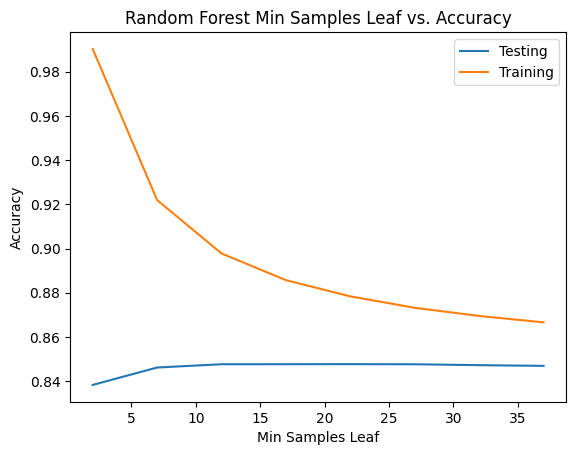

In [ ]:
# Test RandomForest with different min_samples_leaf
min_samples_leaf = np.arange(2, 40 + 1, 5)
accuracies = np.zeros((len(min_samples_leaf), 6))
for (i, num) in enumerate(min_samples_leaf):
    clf = RandomForestClassifier(n_estimators=1000, random_state=0, criterion="entropy")
    clf.set_params(min_samples_leaf = num)

    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

plot_accuracies(min_samples_leaf, accuracies[:,[2,3]], True, "Random Forest Min Samples Leaf vs. Accuracy", "Min Samples Leaf", "Accuracy")

# 15 is best -- 0.84798

In [ ]:
# Test RandomForest with different max_leaf_nodes
max_leaf_nodes = np.arange(10, 500, 40)
accuracies = np.zeros((len(max_leaf_nodes), 6))
for (i, num) in enumerate(max_leaf_nodes):
    clf = RandomForestClassifier(n_estimators=1000, random_state=0, criterion="entropy")
    clf.set_params(max_leaf_nodes = num)

    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

plot_accuracies(max_leaf_nodes, accuracies[:,[2,3]], True, "Random Forest Max Leaf Nodes vs. Accuracy", "Max Leaf Nodes", "Accuracy")

# Max test accuracy is 0.8466415 at 90 max leaf nodes

In [ ]:
# Compare RandomForest Gini vs. Entropy loss
num_trials = 100
accuracies = np.zeros((100, 6))
print("Gini: ")
for i in range(num_trials):
    clf = RandomForestClassifier(n_estimators=num, random_state=0, criterion="gini")
    clf.set_params(max_depth = depth)

    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

print(f'ROC AUC Testing Accuracy: {np.mean(accuracies[:,0])}')
print(f'ROC AUC Training Accuracy: {np.mean(accuracies[:,1])}')
print(f'ROC AUC Testing Accuracy with Probabilities: {np.mean(accuracies[:,2])}')
print(f'ROC AUC Training Accuracy with Probabilities: {np.mean(accuracies[:,3])}')
print(f'Testing Accuracy: {np.mean(accuracies[:,4])}')
print(f'Training Accuracy: {np.mean(accuracies[:,5])}')

num_trials = 100
accuracies = np.zeros((100, 6))
print("Entropy: ")
for i in range(num_trials):
    clf = RandomForestClassifier(n_estimators=num, random_state=0, criterion="entropy")
    clf.set_params(max_depth = depth)

    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

print(f'ROC AUC Testing Accuracy: {np.mean(accuracies[:,0])}')
print(f'ROC AUC Training Accuracy: {np.mean(accuracies[:,1])}')
print(f'ROC AUC Testing Accuracy with Probabilities: {np.mean(accuracies[:,2])}')
print(f'ROC AUC Training Accuracy with Probabilities: {np.mean(accuracies[:,3])}')
print(f'Testing Accuracy: {np.mean(accuracies[:,4])}')
print(f'Training Accuracy: {np.mean(accuracies[:,5])}')

##Model 3: Gradient Boosted Decision Trees

In [ ]:
# Test Gradient Boosting on Different Max Depths
max_depths = [1, 2, 3, 4, 5]
accuracies = np.zeros((len(max_depths), 6))
for (i, depth) in enumerate(max_depths):
    print("Depth: " + str(depth))
    clf = GradientBoostingClassifier(max_depth=depth, random_state=0)

    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

    print(f'ROC AUC Testing Accuracy: {accuracies[i,0]}')
    print(f'ROC AUC Training Accuracy: {accuracies[i,1]}')
    print(f'ROC AUC Testing Accuracy with Probabilities: {accuracies[i,2]}')
    print(f'ROC AUC Training Accuracy with Probabilities: {accuracies[i,3]}')
    print(f'Testing Accuracy: {accuracies[i,4]}')
    print(f'Training Accuracy: {accuracies[i,5]}')

plot_accuracies(max_depths, accuracies[:,[2,3]], True, "Gradient Boosting Max Depth vs. Accuracy", "Max Depth", "Accuracy")

In [ ]:
# Test Gradient Boosting with different n_estimators
num_estimators = [50, 100, 120, 150, 170, 200]
accuracies = np.zeros((len(max_depths), 6))
for (i, num) in enumerate(num_estimators):
    print("Number of Estimators: " + str(num))
    clf = GradientBoostingClassifier(n_estimators=num, max_depth=2, random_state=0)

    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

    print(f'ROC AUC Testing Accuracy: {accuracies[i,0]}')
    print(f'ROC AUC Training Accuracy: {accuracies[i,1]}')
    print(f'ROC AUC Testing Accuracy with Probabilities: {accuracies[i,2]}')
    print(f'ROC AUC Training Accuracy with Probabilities: {accuracies[i,3]}')
    print(f'Testing Accuracy: {accuracies[i,4]}')
    print(f'Training Accuracy: {accuracies[i,5]}')

plot_accuracies(num_estimators accuracies[:,[2,3]], True, "Gradient Boosting Num Estimators vs. Accuracy", "Num Estimators", "Accuracy")

##Model 4: Fully Connected Neural Network

Neural network model 1: optimized for hyperparameters using Optuna.

In [ ]:
num_epochs=500

accuracy_list = []
combined = combine_related_columns(numerize_csv('train.csv',expand_classes=True))
Y = combined['Discontinued']

num_to_drop = np.random.randint(2, 6)

X = combined.drop('Discontinued', axis=1)
column_names = X.columns

columns_to_drop = np.random.choice(column_names, num_to_drop, replace=False)

X.drop(columns_to_drop, axis=1, inplace=True)

inputs = X.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, train_size = .75)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

y_train_tensor = y_train_tensor.view(-1, 1)
y_test_tensor = y_test_tensor.view(-1, 1)
def objective(trial):
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.9)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    num_hidden_units = trial.suggest_int('num_hidden_units', 32, 256)

    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(inputs, num_hidden_units),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(num_hidden_units, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 40),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(40, 1),
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    accuracy_list = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = loss_fn(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        model.eval()

        with torch.no_grad():
            outputs = model(X_test_tensor)
            output_np = outputs.cpu().detach().numpy().flatten()
            y_np = y_test_tensor.cpu().detach().numpy().flatten()
            prob_roc = roc_auc_score(y_np, output_np)
            accuracy_list.append(prob_roc)

    return -np.mean(accuracy_list)  # Minimize negative mean accuracy

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

best_params = study.best_params
best_accuracy = -study.best_value

print(f"Best Parameters: {best_params}")
print(f"Highest Accuracy: {best_accuracy}")

In [ ]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

fig=plot_optimization_history(study)
fig.show()
fig=plot_param_importances(study)
fig.show()
fig=plot_parallel_coordinate(study)
fig.show()
fig=plot_contour(study)
fig.show()
fig=plot_rank(study)
fig.show()
fig=plot_intermediate_values(study)
fig.show()

Neural network model 2

In [ ]:
# Define the model
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(19, 1000),
    nn.LeakyReLU(),
    nn.Dropout(0.8),
    nn.Linear(1000, 500),
    nn.LeakyReLU(),
    nn.Dropout(0.3),
    nn.Linear(500, 200),
    nn.LeakyReLU(),
    nn.Dropout(0.3),
    nn.Linear(200, 30),
    nn.LeakyReLU(),
    nn.Dropout(0.3),
    nn.Linear(30, 1),
)

# Parameters
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

combined = numerize_csv('train.csv', target_encode=True)

#Data
Y = combined['Discontinued']
X = combined.drop('Discontinued', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, train_size = .75)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

y_train_tensor = y_train_tensor.view(-1, 1)
y_test_tensor = y_test_tensor.view(-1, 1)

test_scores = []
train_scores = []
test_accs = []

# Training
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_tensor)
    loss = loss_fn(outputs, y_train_tensor)
    train_scores.append(roc_auc_score(y_train_tensor.detach().numpy(), outputs.detach().numpy()))
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        # test_loss = loss_fn(outputs, y_test_tensor)
        test_scores.append(roc_auc_score(y_test_tensor, outputs))
        test_accs.append(accuracy_score(y_test_tensor, torch.round(outputs)))

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend()

##Model 5: XGBoost

In [ ]:
raw = numerize_csv('train.csv', expand_classes=True)
# combined=combine_related_columns(raw)

Y = raw['Discontinued'].to_numpy()
X = raw.drop('Discontinued', axis=1).to_numpy()

kf = KFold(n_splits=5)

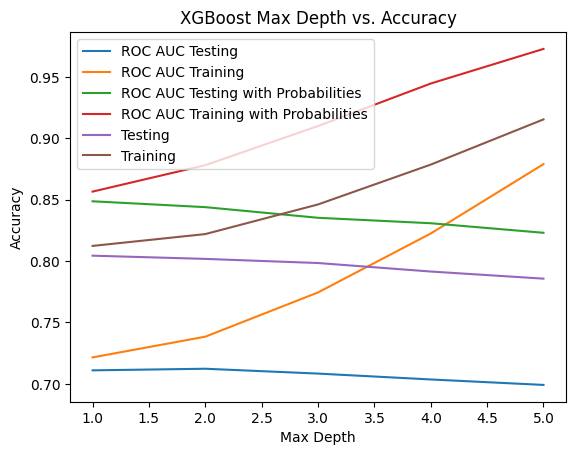

In [ ]:
# Test with different max_depths
max_depths = [1, 2, 3, 4, 5]
accuracies = np.zeros((len(max_depths), 6))
for (i, depth) in enumerate(max_depths):
    clf = xgb.XGBClassifier(max_depth=depth, random_state=0)
    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

plot_accuracies(max_depths, accuracies, False, "XGBoost Max Depth vs. Accuracy", "Max Depth", "Accuracy")

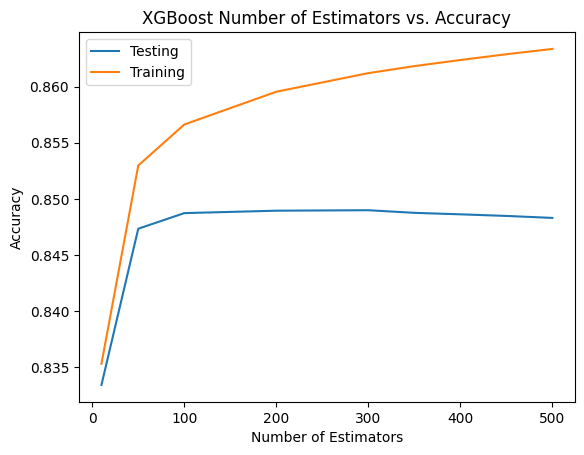

In [ ]:
# Test with different n_estimators
num_estimators = [10, 50, 100, 200, 300, 350, 400, 450, 500]
accuracies = np.zeros((len(num_estimators), 6))
for (i, num) in enumerate(num_estimators):
    clf = xgb.XGBClassifier(max_depth=1, n_estimators=num, random_state=0)

    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

plot_accuracies(num_estimators, accuracies[:,[2,3]], True, "XGBoost Number of Estimators vs. Accuracy", "Number of Estimators", "Accuracy")

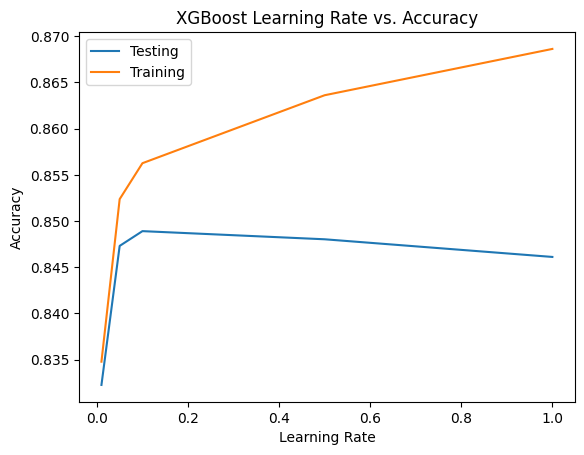

In [ ]:
# Test with different learning_rates
lrs = [1, 0.5, 0.1, 0.05, 0.01]
accuracies = np.zeros((len(lrs), 6))
for (i, lr) in enumerate(lrs):
    clf = xgb.XGBClassifier(max_depth=1, n_estimators=300, learning_rate = lr, random_state=0)

    accuracies[i] = get_cross_validation_accuracies(clf, kf, X, Y)

plot_accuracies(lrs, accuracies[:,[2,3]], True, "XGBoost Learning Rate vs. Accuracy", "Learning Rate", "Accuracy")

In [ ]:
# Generate submission using test.csv
raw_test = numerize_csv('test.csv', train=False, expand_classes=True)

clf = xgb.XGBClassifier(max_depth=1, n_estimators=300, learning_rate = 0.1, random_state=0)
clf.fit(X, Y)
y_test_prob_preds = clf.predict_proba(raw_test)
write_submission(y_test_prob_preds[:, 1])

##Model 6: Autogluon

In [ ]:
def minimal_numerize_csv():
    df = pd.read_csv('train.csv').drop('customerID', axis=1)
    df['Discontinued'] = (df['Discontinued'] == 'Yes').astype(float)
    return df

train_data = TabularDataset(minimal_numerize_csv("train.csv"))
predictor = TabularPredictor(label='Discontinued', problem_type='regression').fit(train_data=train_data, presets='best_quality',num_gpus=1,time_limit=3600*8)

# Predict the data on the test.csv data
data=numerize_csv("test.csv",expand_classes=True,train=False)
y = predictor.predict(data)
write_submission(y)

##Final Ensemble Model

We combined results from our best Adaboost model, XGBoost model, neural network, and AutoGluon with the weights being approximately 0.291, 0.200, 0.145, and 0.364